In [3]:
import nest_asyncio
nest_asyncio.apply()

from hddCRP.modelBuilder import cdCRP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statannotations.Annotator import Annotator

import os

In [4]:
session_numbers = [1]; # index by 1

overwrite_existing_results = False
results_directory = "Results/individualFit/"

if(not os.path.exists(results_directory)):
    os.makedirs(results_directory)

context_depth = 2;
nback_depth = 1;

data_filename = 'data/Data_turns_all_by_session.pkl';
with open(data_filename, 'rb') as data_file:
    data = pickle.load(data_file)

subjects = list(data["data"].keys())
subjects.sort()
print("subjects = " + str(subjects))

action_labels = [0,1,2]

subjects = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'D1', 'D2', 'E1', 'E2', 'F1', 'F2', 'G1', 'G2', 'H1', 'I1', 'I2', 'J1', 'J2']


In [5]:
start_session = np.min(session_numbers)
end_session = np.max(session_numbers)
fit_file = f"{results_directory}/fits_session_{start_session}"
fit_summary_file = f"{results_directory}/fit_summary_session_{start_session}"
if(end_session != start_session):
    fit_file += f"_to_{start_session}"
    fit_summary_file  += f"_to_{start_session}"
    
if(nback_depth != 1 or context_depth != 2):
    fit_file += f"_cd{context_depth}_nb{nback_depth}"
    fit_summary_file  += f"_cd{context_depth}_nb{nback_depth}"

fit_file += f".pkl"
fit_summary_file += f".pkl"

if(not os.path.isfile(fit_file) or overwrite_existing_results):
    data_fits = pd.DataFrame()
    data_fit_metrics = pd.DataFrame()
    for subject_index, subject in enumerate(subjects):
        print(f"subject {subject} ")
        sequences_0 = data["data"][subject]["data"]; # turns in each session
        session_types_0 = data["data"][subject]["task"] # which maze

        ii = list(np.where(np.array(session_types_0)=='C')[0][np.array(session_numbers)-1]) # sessions in map C
        sequences     = [sequences_0[xx] for xx in ii]
        session_types = [session_types_0[xx] for xx in ii]

        stan_seed = (subject_index+1) * 1000 + start_session

        # build model with given sequences
        model = cdCRP(sequences, session_labels=session_types, subject_labels=subject, possible_observations=action_labels);

        # set model depth
        model.same_nback_depth = nback_depth
        model.context_depth = context_depth

        # fit with Stan
        model.build(random_seed=stan_seed);
        model.fit_model()

        map_fit = model.get_map()
        fit_df  = model.fit.to_frame()
        summary_df = model.fit_summary()

        fit_df["subject"] = subject
        fit_df["start_session_C"] = start_session
        fit_df["end_session_C"] = end_session
        summary_df["subject"] = subject
        summary_df["MAP"] = pd.Series(map_fit)
        summary_df["start_session_C"] = start_session
        summary_df["end_session_C"] = end_session

        data_fit_metrics = pd.concat([data_fit_metrics,summary_df], copy=False)
        data_fits = pd.concat([data_fits,fit_df], copy=False)

    data_fits.to_pickle(fit_file)
    data_fit_metrics.to_pickle(fit_summary_file)
else:
    print("fit file found")



subject A1 
Building...

/home/latimerk/.cache/httpstan/4.10.1/models/k5u4i3e6/model_k5u4i3e6.cpp: In constructor ‘model_k5u4i3e6_namespace::model_k5u4i3e6::model_k5u4i3e6(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/latimerk/.cache/httpstan/4.10.1/models/k5u4i3e6/model_k5u4i3e6.cpp:675:17: warning: variable ‘bb_c’ set but not used [-Wunused-but-set-variable]
             int bb_c = std::numeric_limits<int>::min();
                 ^~~~
In file included from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124:0,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
            


Building: 47.3s, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000

subject A2 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject B1 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   5% (401/8000)
Sampling:   6% (501/8000)
Sampling:   8% (600/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:

subject B2 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   5% (401/8000)
Sampling:   6% (501/8000)
Sampling:   8% (600/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling: 

subject C1 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   5% (401/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  11% (900/8000)
Sampling:  14% (1100/8000)
Sampling:  18% (1400/8000)
Sampling:

subject C2 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (401/8000)
Sampling:   6% (501/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  11% (900/8000)
Sampling:  

subject D1 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   3% (203/8000)
Sampling:   5% (402/8000)
Sampling:   8% (601/8000)
Sampling:  10% (800/8000)
Sampling:  14% (1100/8000)
Sampling:  19% (1500/8000)
Sampling:  22% (1800/8000)
Sampling:  26% (2100/8000)
Samplin

subject D2 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject E1 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject E2 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject F1 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject F2 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   4% (302/8000)
Sampling:   5% (402/8000)
Sampling:   8% (601/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling

subject G1 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  11% (900/8000)
Sampling:  

subject G2 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject H1 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject I1 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject I2 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject J1 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject J2 
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

<Figure size 1000x600 with 0 Axes>

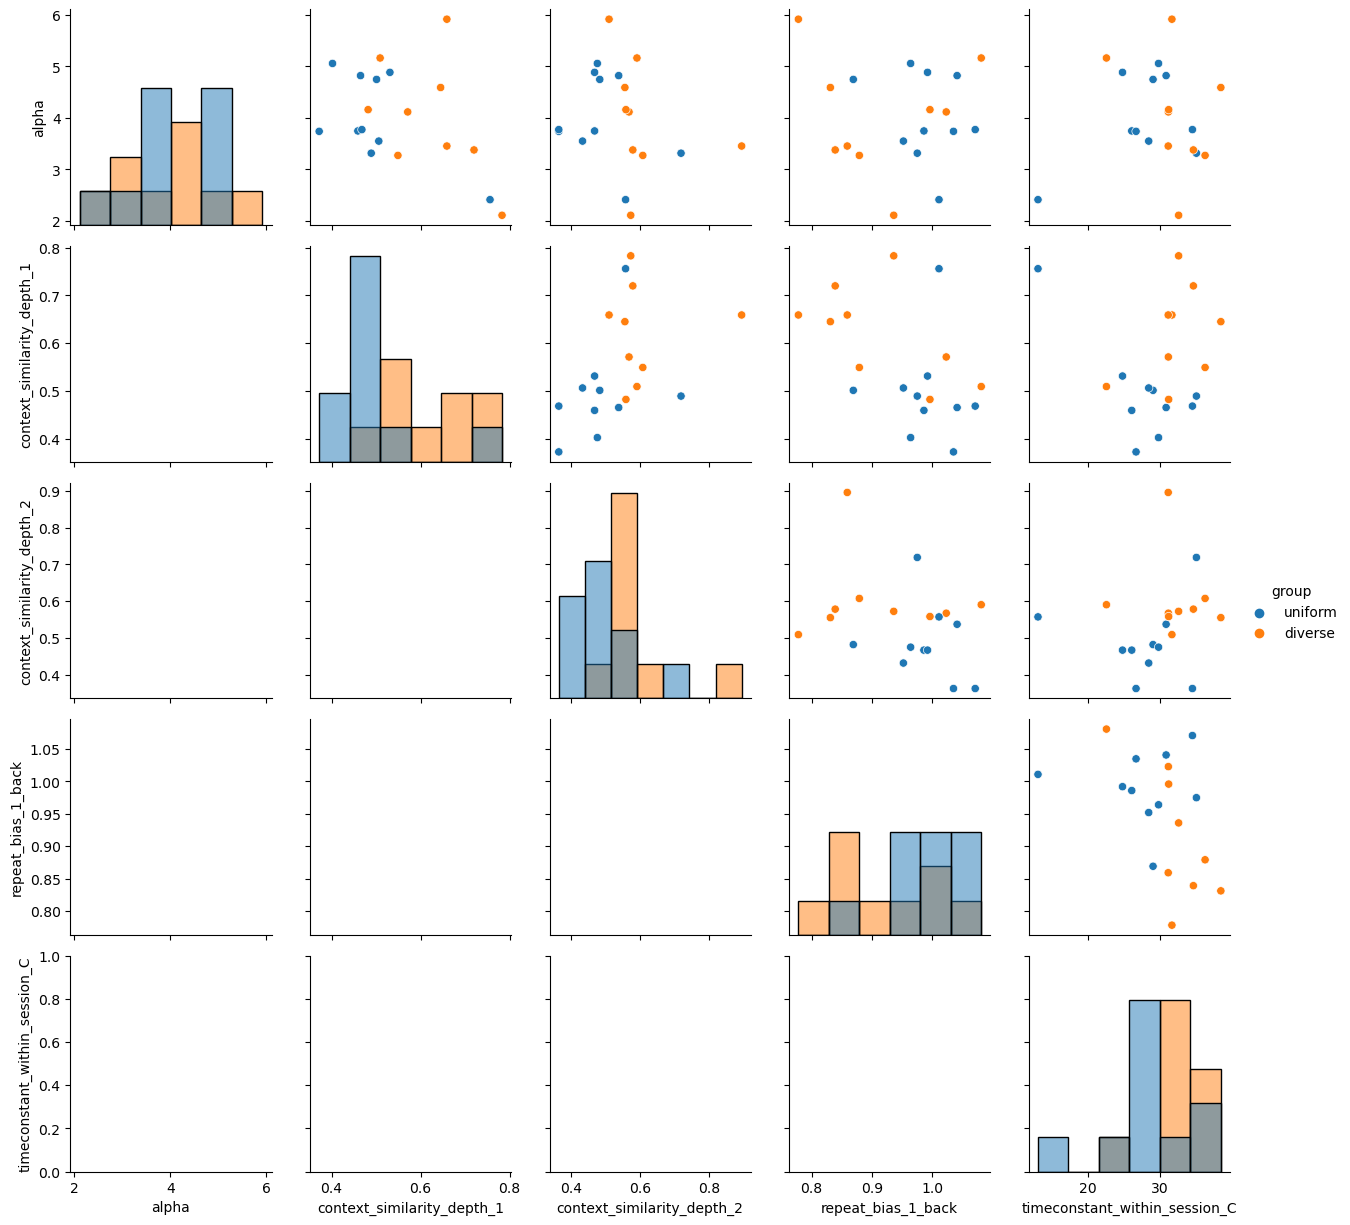

In [6]:
fit_summary = pd.read_pickle(fit_summary_file)
group_names = np.array(["uniform", "diverse"])

mapping = {}
for jj in range(2):
    for ii in data["group_definition"][group_names[jj]]:
        mapping[ii] = group_names[jj]
fit_summary["group"] = fit_summary["subject"].map(mapping)

params = list(fit_summary.index.unique())

fit_summary.index.name = 'parameter'
fit_summary = fit_summary.reset_index()

estimator_to_plot = "median"

formatted_fit = fit_summary.pivot(index="subject", columns=["parameter"],values=[estimator_to_plot]).droplevel(0,axis=1)
formatted_fit["group"] = fit_summary[["group","subject"]].drop_duplicates("subject").set_index("subject")

#     print(fit_summary["median"][fit_summary["parameter"] == ii])
plt.figure(figsize=(10,6))
g = sns.PairGrid(formatted_fit, hue="group")
g.map_upper(sns.scatterplot)
g.map_diag(sns.histplot)
g.add_legend()
# fit_summary[["median","subject"]].set_index("subject")

timeconstant_within_session_C_uniform vs. timeconstant_within_session_C_diverse: Mann-Whitney-Wilcoxon test two-sided, P_val:4.546e-02 U_stat=2.000e+01


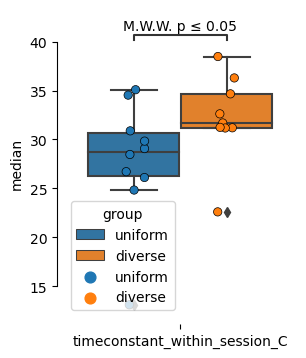

In [7]:

grps = [["timeconstant_within_session_C"], ["alpha"], ["repeat_bias_1_back", "context_similarity_depth_1", "context_similarity_depth_2"]]
ii = 0
plt.figure(figsize=(len(grps[ii])*3,4))
fit_summary2 = fit_summary[["group", estimator_to_plot, "parameter"]]
ax = sns.boxplot(data=fit_summary2, x="parameter", y=estimator_to_plot, order=grps[ii], hue_order=["uniform", "diverse"],
            hue="group")

pairs = [((xx, "uniform"), (xx, "diverse")) for xx in grps[ii]]
annot = Annotator(ax, pairs=pairs, data=fit_summary2, x="parameter", y=estimator_to_plot, order=grps[ii], hue="group", hue_order=["uniform", "diverse"])
#Annotator.new_plot(ax=ax, pairs=pairs, data=fit_summary2, x="parameter", y=estimator_to_plot, order=grps[ii], hue="group", hue_order=["uniform", "diverse"])
annot.configure(test='Mann-Whitney', verbose=2, text_format='simple')
annot.apply_test()
annot.annotate()
sp = sns.stripplot(data=fit_summary2,  x="parameter", y=estimator_to_plot, hue="group", order=grps[ii], hue_order=["uniform", "diverse"],
              dodge=True, size=6, alpha=1,  edgecolor=[0,0,0], linewidth=0.5)
sns.despine(offset=5, trim=True);
plt.xlabel(None);


alpha_uniform vs. alpha_diverse: Mann-Whitney-Wilcoxon test two-sided, P_val:9.025e-01 U_stat=4.700e+01


Text(0.5, 14.722222222222216, '')

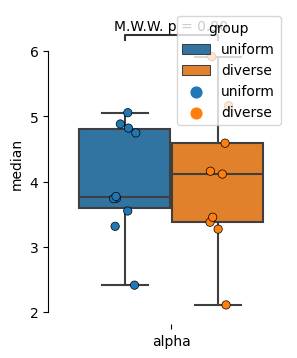

In [8]:
ii = 1
plt.figure(figsize=(len(grps[ii])*3,4))
ax = sns.boxplot(x="parameter", y=estimator_to_plot, order=grps[ii], hue_order=["uniform", "diverse"],
            hue="group",
            data=fit_summary2)

pairs = [((xx, "uniform"), (xx, "diverse")) for xx in grps[ii]]
annot = Annotator(ax, pairs=pairs, data=fit_summary2, x="parameter", y=estimator_to_plot, order=grps[ii], hue="group", hue_order=["uniform", "diverse"])
annot.configure(test='Mann-Whitney', verbose=2, text_format='simple')

annot.apply_test()
annot.annotate()

sns.stripplot(data=fit_summary2, x="parameter", y=estimator_to_plot, hue="group", size=6, order=grps[ii], hue_order=["uniform", "diverse"],
             dodge=True, alpha=1,  edgecolor=[0,0,0], linewidth=0.5)
sns.despine(offset=5, trim=True)
plt.xlabel(None)

context_similarity_depth_1_uniform vs. context_similarity_depth_1_diverse: Mann-Whitney-Wilcoxon test two-sided, P_val:1.008e-02 U_stat=1.300e+01
repeat_bias_1_back_uniform vs. repeat_bias_1_back_diverse: Mann-Whitney-Wilcoxon test two-sided, P_val:1.113e-01 U_stat=6.500e+01
context_similarity_depth_2_uniform vs. context_similarity_depth_2_diverse: Mann-Whitney-Wilcoxon test two-sided, P_val:6.188e-03 U_stat=1.100e+01


Text(0.5, 14.581597222222216, '')

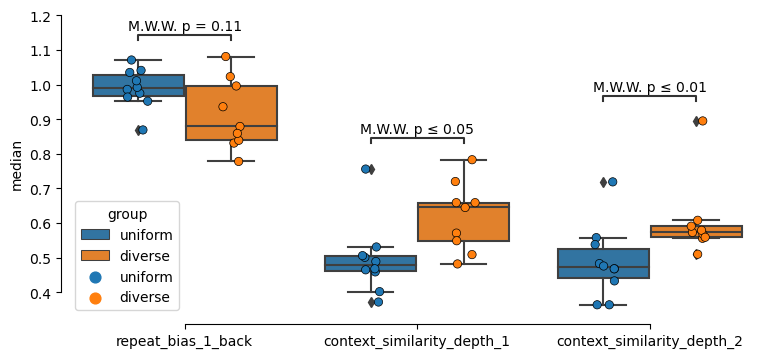

In [9]:
ii = 2
plt.figure(figsize=(len(grps[ii])*3,4))
ax = sns.boxplot(x="parameter", y=estimator_to_plot, order=grps[ii], hue_order=["uniform", "diverse"],
            hue="group",
            data=fit_summary2)

pairs = [((xx, "uniform"), (xx, "diverse")) for xx in grps[ii]]
annot = Annotator(ax, pairs=pairs, data=fit_summary2, x="parameter", y=estimator_to_plot, order=grps[ii], hue="group", hue_order=["uniform", "diverse"])
#Annotator.new_plot(ax=ax, pairs=pairs, data=fit_summary2, x="parameter", y=estimator_to_plot, order=grps[ii], hue="group", hue_order=["uniform", "diverse"])
annot.configure(test='Mann-Whitney', verbose=2, text_format='simple')
annot.apply_test()
annot.annotate()
sns.stripplot(data=fit_summary2, x="parameter", y=estimator_to_plot, hue="group", size=6, order=grps[ii], hue_order=["uniform", "diverse"],
             dodge=True, alpha=1,  edgecolor=[0,0,0], linewidth=0.5)
sns.despine(offset=5, trim=True)
plt.xlabel(None)

In [10]:
fit_summary.head()

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,...,25.0%,97.5%,95.0%,90.0%,75.0%,subject,MAP,start_session_C,end_session_C,group
0,alpha,4.263,2.477,0.744,8.879,0.039,0.030,3833.0,2592.0,1.0,...,2.448,10.237,8.930,7.627,5.563,A1,2.225087,1,1,uniform
1,timeconstant_within_session_C,33.427,25.400,2.721,80.821,0.398,0.302,3925.0,2570.0,1.0,...,15.408,101.106,84.356,67.296,43.879,A1,12.279903,1,1,uniform
2,repeat_bias_1_back,1.002,0.210,0.607,1.382,0.003,0.002,4798.0,3241.0,1.0,...,0.855,1.456,1.375,1.273,1.135,A1,0.941693,1,1,uniform
3,context_similarity_depth_1,0.467,0.274,0.010,0.912,0.004,0.003,4845.0,2649.0,1.0,...,0.232,0.953,0.918,0.848,0.695,A1,0.538066,1,1,uniform
4,context_similarity_depth_2,0.473,0.272,0.000,0.903,0.004,0.003,4328.0,2472.0,1.0,...,0.246,0.955,0.915,0.850,0.697,A1,0.594861,1,1,uniform


In [11]:
x = fit_summary.pivot(index="subject", columns=["parameter"],values=[estimator_to_plot]).droplevel(0,axis=1)
x["group"] = fit_summary[["group","subject"]].drop_duplicates("subject").set_index("subject")
# fit_summary.pivot(index="subject", columns=["parameter"], values=["group"])
x

parameter,alpha,context_similarity_depth_1,context_similarity_depth_2,repeat_bias_1_back,timeconstant_within_session_C,group
subject,,,,,,
A1,3.748,0.459,0.468,0.986,26.119,uniform
A2,4.591,0.645,0.556,0.831,38.472,diverse
B1,3.316,0.489,0.719,0.975,35.083,uniform
B2,4.117,0.571,0.568,1.023,31.195,diverse
C1,4.885,0.531,0.468,0.992,24.839,uniform
C2,3.379,0.720,0.579,0.839,34.663,diverse
D1,4.748,0.501,0.483,0.869,29.073,uniform
D2,5.917,0.659,0.510,0.778,31.688,diverse
E1,3.740,0.372,0.364,1.035,26.716,uniform
